# Семинар 4 - Интерполяция изображений, геометрия формирования изображения и калибровка камеры

***

In [15]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Интерполяция изображений

![](data/interpolation.svg)
Задача - эффективно уменьшить/увеличить изображение.

Рассмотрим несколько методов интерполяции.

## а) Интерполяция по ближайшему пикселю

![](data/inter_nearest.png)

Самая простая и самая быстрая, однако она приводит к сильным артефактам.

## б) Билинейная интерполяция

![](data/inter_linear.png)

Лучше по качеству, но требует больше вычислений и вдобавок размывает границы объектов.

## в) Бикубическая интерполяция

![](data/inter_cubic.png)

Еще лучше в непрерывных областях, но на границе возникает [эффект гало](https://ru.wikipedia.org/wiki/Гало) (более темная полоса вдоль темного края границы и светлая вдоль светлого).

## Примеры

Согласно [документации OpenCV](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является `cv.INTER_AREA`,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: `cv.INTER_CUBIC` (медленный) и `cv.INTER_LINEAR`.

In [16]:
interpolation_algorithm = [
    ("nearest", cv2.INTER_NEAREST),
    ("bilinear", cv2.INTER_LINEAR),
    ("bicubic", cv2.INTER_CUBIC),
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}')

    fig, axes = plt.subplots(
        nrows=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(3, 20)
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized, cmap='Greys_r')
        axes[i].set_title(
            f"{interpolation_algorithm[i][0]}, shape = {img_resized.shape}",
        )

### Оригинальное изображение

Text(0.5, 1.0, 'Original image, shape = (50, 50)')

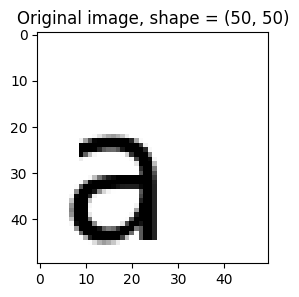

In [17]:
IMG_PATH = "data/a_letter.png"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_04/data .

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(3, 3))
plt.imshow(a_letter_img, cmap="Greys_r")
plt.title(f"Original image, shape = {a_letter_img.shape}")

### Увеличение

orig size: h=50, w=50, resised size: h=250, w=250


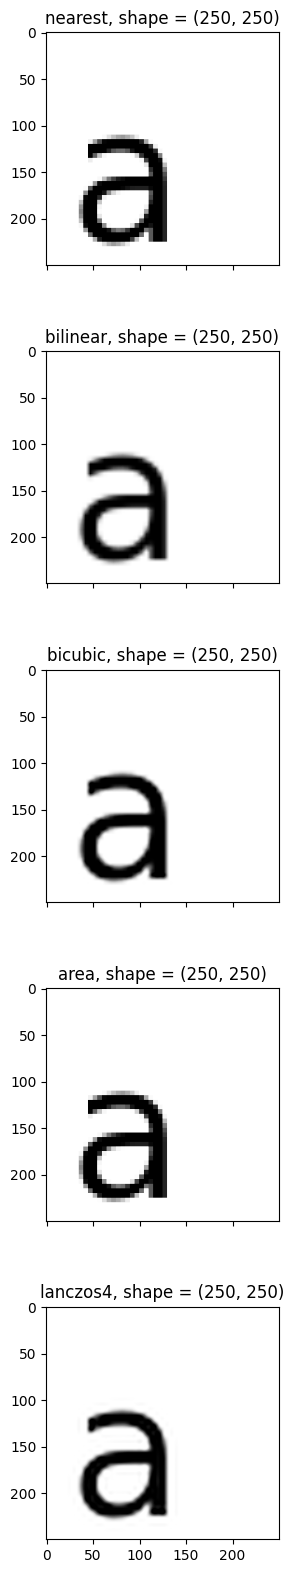

In [18]:
resize_by_factor(
    img=a_letter_img,
    factor=5,
)

### Уменьшение

orig size: h=50, w=50, resised size: h=25, w=25


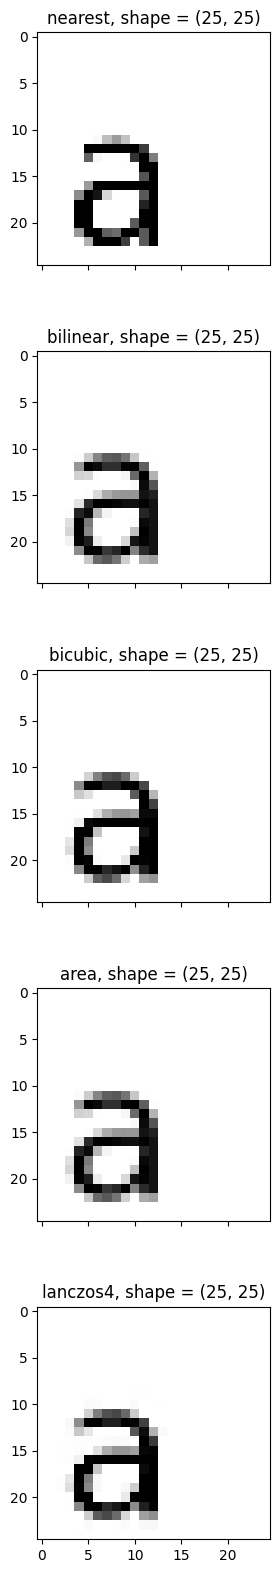

In [19]:
resize_by_factor(
    img=a_letter_img,
    factor=0.5,
)

# Упражение 1

Можно ли реализовать сжатие изображений на свертках? Реализуйте свертку, которая будет уменьшать изображение в 2 раза.

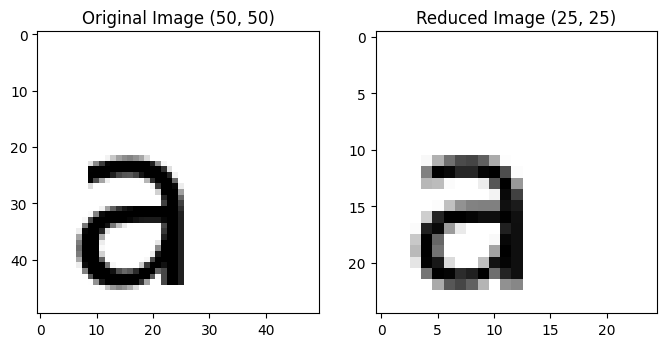

In [20]:
def apply_convolution(image_data, filter_matrix, stride_length=1):
    img_height, img_width = image_data.shape
    filter_height, filter_width = filter_matrix.shape

    padding_height = (filter_height - 1) // 2
    padding_width = (filter_width - 1) // 2

    padded_img = np.pad(image_data, ((padding_height, padding_height), (padding_width, padding_width)), 'constant')

    output_height = (img_height + 2 * padding_height - filter_height) // stride_length + 1
    output_width = (img_width + 2 * padding_width - filter_width) // stride_length + 1
    convoluted_img = np.zeros((output_height, output_width))

    for y in range(0, img_height + 2 * padding_height - filter_height + 1, stride_length):
        for x in range(0, img_width + 2 * padding_width - filter_width + 1, stride_length):
            filtered_value = np.sum(padded_img[y:y+filter_height, x:x+filter_width] * filter_matrix)
            filtered_value = np.clip(filtered_value, 0, 255)
            convoluted_img[y // stride_length, x // stride_length] = filtered_value

    return convoluted_img

fig, axes = plt.subplots(1, 2, figsize=(8, 8))

averaging_filter = np.array([[1, 1], [1, 1]], dtype=np.float32) / 4
reduced_image = apply_convolution(a_letter_img, averaging_filter, stride_length=2)

axes[0].imshow(a_letter_img, cmap='gray')
axes[0].set_title(f"Original Image {a_letter_img.shape}")

axes[1].imshow(reduced_image, cmap='gray')
axes[1].set_title(f"Reduced Image {reduced_image.shape}")
plt.show()


# Трансформация изображений

[Туториал OpenCV "Geometric Transformations of Images"](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html)

![](data/image_transformations.png)
_Источник - [Computer Vision: Algorithms and Applications, 2nd ed. 2022 Richard Szeliski](https://szeliski.org/Book/)_

## Поворот (Rotation)

Входные параметры: угол поворота (angle)

```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```

## Растяжение/сжатие (Scale)

Входные параметры: фактор растяжения (tx, ty)

```python
matrix = np.array([
      [t[0], 0,    0],
      [0,    t[1], 0],
      [0,    0,    1],
])
```

## Перенос (translation)

Входные параметры: фактор переноса (tx, ty)

```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

## Сдвиг (shearing)

Входные параметры: фактор сдвига (tx, ty)

```python
matrix_horisontal = np.array([
      [1,    t[0], 0],
      [t[1], 1,    0],
      [0,    0,    1],
])
```


# Упражнение 2

Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Не забудьте про центрирование.

Идея - афинное перемещение пикселей изображения.

In [21]:
def affine_transform(
    img: np.array,
    mat: np.array,
) -> np.array:
    image_height, image_width = img.shape[:2]

    transformed_img = np.zeros_like(img)
    center_x, center_y = (image_width - 1) / 2, (image_height - 1) / 2

    pixels_outside = 0
    for i in range(image_height):
        for j in range(image_width):
            original_point = np.array([j - center_x, i - center_y, 1])
            transformed_point = np.dot(mat, original_point)
            new_j, new_i, _ = transformed_point
            new_j, new_i = int(new_j + center_x), int(new_i + center_y)

            if 0 <= new_i < image_height and 0 <= new_j < image_width:
                transformed_img[new_i, new_j] = img[i, j]
    return transformed_img


def make_rotation(
    params,
) -> np.array:

    angle = params[0]
    theta = np.radians(angle)
    mat = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
        
    return mat

def make_scaling(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array(
        [
        [tx, 0, 0],
        [0, ty, 0],
        [0, 0, 1]
    ]
    )

    return mat

def make_translation(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array(
    [
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ]
    )

    return mat

def make_shearing(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
        [1, tx, 0],
        [ty, 1, 0],
        [0, 0, 1]
    ])

    return mat

Проверьте код на примере изображения c астронавтом

In [ ]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    tx=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),

    ty=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
    angle=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
)
def play_with_params(
    tx: float,
    ty: float,
    angle: float
) -> None:

    mat_rotate = make_rotation(
        (angle,),
    )

    mat_scale = make_scaling(
        (tx, ty),
    )

    mat_translation = make_translation(
        (tx, ty),
    )

    mat_shearing = make_shearing(
        (tx, ty),
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for idx, mat in enumerate([mat_rotate, mat_scale, mat_translation, mat_shearing]): 
        transformed_img = affine_transform(
            img=img,
            mat=mat
        )
        axes[idx // 2, idx % 2].imshow(transformed_img)

    plt.show()

# Вопрос 1

Запустите все 4 преобразования. Изменяйте параметры алгоритма. Имеются ли пиксели, которые никуда не перешли в результате трансформации?

**Ответ:**


При изменении параметров все виды трансформаций, кроме сдвига, могут приводить к появлению артефактов в виде черных пикселей. Кроме того, некоторые пиксели могут выходить за пределы изображения и не переносятся на новое место

# Формирование изображения

## Внешние параметры камеры

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

**Радиальные искажения** возникают из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.

**Тангенциальные искажения** возникают из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

Формулы:

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

# Вопрос 2

Запишите выражение связи точек в координатной системе камеры (x, y, z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

**Ответ:** $$
\begin{pmatrix}
u \\ v \\ w
\end{pmatrix}
=
\begin{pmatrix}
f_x & \gamma & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z
\end{pmatrix}
\begin{pmatrix}
x \\ y \\ z \\ 1
\end{pmatrix}
$$

# Упражнение 3

Найдите параметры вашей камеры мобильного телефона. 

Используйте шаблон шахматной доски. Можете воспользоваться ресурсом https://markhedleyjones.com/projects/calibration-checkerboard-collection  - здесь можно выбрать необходимый размер и подготовить pdf с доской. Во время печати не забудьте проверить, что масштаб не меняется (часто в параметрах печати по умолчанию установлен флаг "scale to fit page").

Воспользуйтесь [туториалом OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

В ответе требуется:

1. Загрузить все сделанные фотографии (туториал рекомендует использовать не менее 10-ти изображений) в папку `./data/calibr_images`. Написанный код должен воспроизводить ваши результаты без дополнительных манипуляций.
2. Вывести найденные параметры калибровки (intrinsic матрицу и параметры дисторсии).
3. Отобразить изображения до и после устранения дисторсии.
4. Посчитать ошибку репроектирования (см. туториал opencv).

In [23]:

import cv2 as cv
import glob
col = 5
row = 4
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((row*col,3), np.float32)
objp[:,:2] = np.mgrid[0:row,0:col].T.reshape(-1,2)
 
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
images = glob.glob('data/calibr_images/*.jpg')
 
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (row,col), None)
 
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
 
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
 
        # Draw and display the corners
        cv.drawChessboardCorners(img, (row,col), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
cv.destroyAllWindows()

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread (0x31b9340).
Cannot move to target thread (0x21f1680)

QObject::moveToThread: Current thread (0x21f1680) is not the object's thread

In [24]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [25]:
img_raw = cv.imread('data/calibr_images/photo_1_2024-03-09_18-45-47.jpg')
h,  w = img_raw.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [26]:
img = cv2.undistort(img_raw, mtx, dist, None, newcameramtx)

x, y, w, h = roi
img = img[y:y+h, x:x+w]

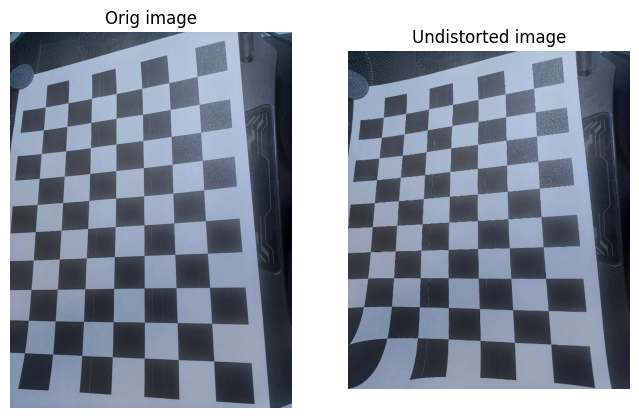

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(img_raw, cmap="gray")
ax[0].set_title(f"Orig image")
ax[0].axis('off')
ax[1].imshow(img, cmap="gray")
ax[1].set_title(f"Undistorted image")
ax[1].axis('off')
plt.show()

Так как обнаружить удалось только доску размером 5 на 4, четко видны артефакты после применения функции undictort, однако, целевая зона действительно стала заметно менее подвержена дисторции

In [28]:
error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error_value = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    error += error_value
print( "total error: {}".format(error/len(objpoints)) )

total error: 0.11680484894207471
